In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("train.csv")
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


Text(0, 0.5, 'Frecuencia')

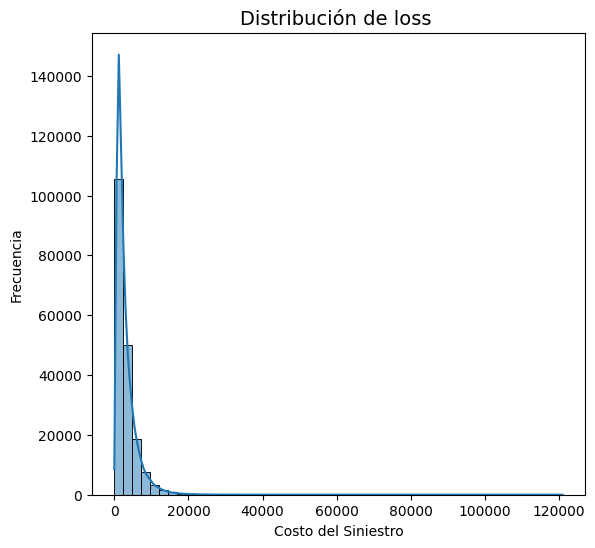

In [2]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['loss'], kde=True, bins=50)
plt.title('Distribución de loss ', fontsize=14)
plt.xlabel('Costo del Siniestro')
plt.ylabel('Frecuencia')

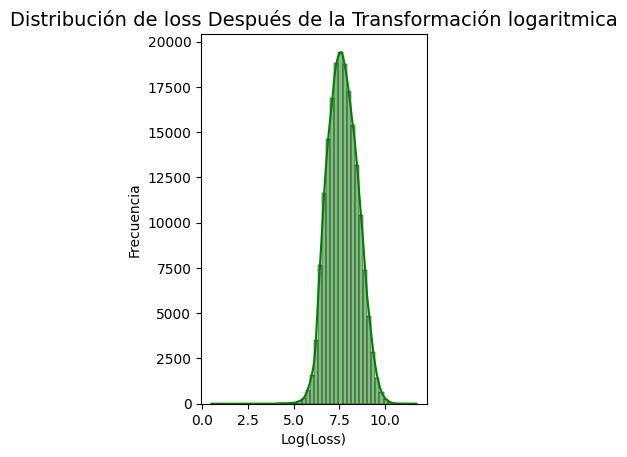

In [3]:
data['log_loss'] = np.log1p(data['loss'])
plt.subplot(1, 2, 2)
sns.histplot(data['log_loss'], kde=True, bins=50, color='green')
plt.title('Distribución de loss Después de la Transformación logaritmica', fontsize=14)
plt.xlabel('Log(Loss)')
plt.ylabel('Frecuencia')
plt.show()

El primer paso en nuestro análisis fue inspeccionar la distribución de la variable objetivo, loss. Como se observa en el primer gráfico, la distribución presenta un fuerte sesgo positivo. Esto indica que la gran mayoría de los siniestros tienen un costo bajo, mientras que unos pocos siniestros tienen un costo excepcionalmente alto, creando una cola larga en la distribución. 

Para corregir esto, aplicamos una transformación logarítmica. El segundo gráfico muestra la distribución de la variable transformada, log_loss. Ahora la distribución es mucho más simétrica y se asemeja a una curva normal, lo que la hace más adecuada para el análisis y el modelado.

In [4]:
cat_features = [col for col in data.columns if 'cat' in col]
print(data[cat_features].nunique().head(10))

cat1     2
cat2     2
cat3     2
cat4     2
cat5     2
cat6     2
cat7     2
cat8     2
cat9     2
cat10    2
dtype: int64


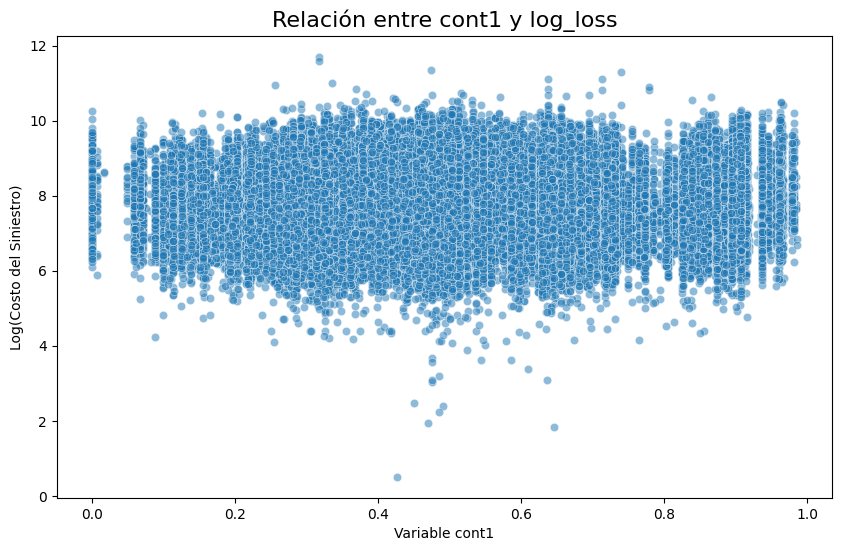

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cont1', y='log_loss', data=data, alpha=0.5)
plt.title(f'Relación entre cont1 y log_loss', fontsize=16)
plt.xlabel(f'Variable cont1')
plt.ylabel('Log(Costo del Siniestro)')
plt.show()

A simple vista, no se observa una relación lineal clara. Los puntos forman una nube densa y dispersa sin una tendencia ascendente o descendente obvia. Esto sugiere que la correlación lineal entre cont1 y log_loss es muy baja.

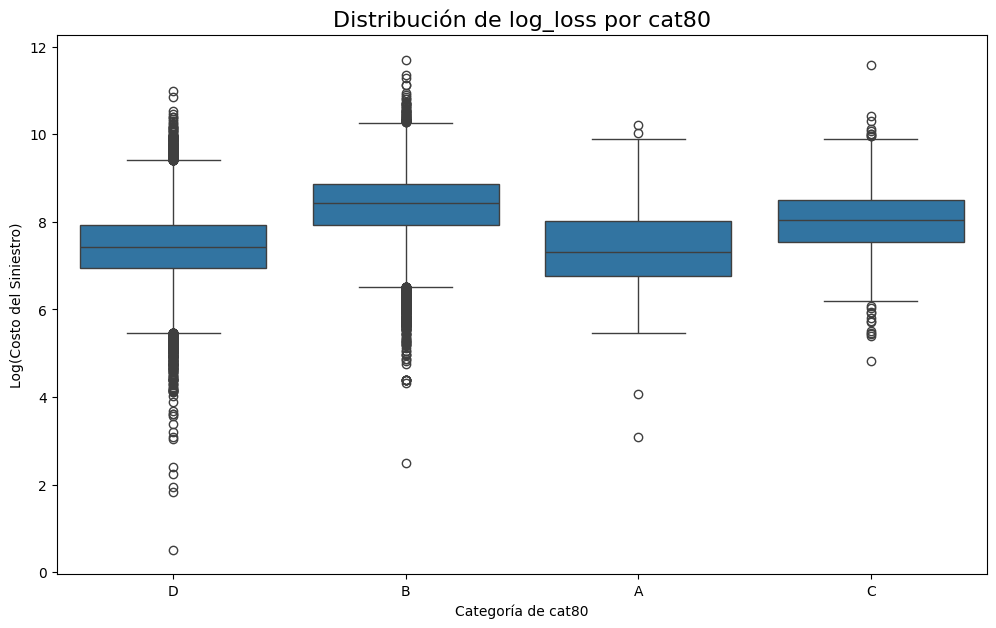

In [8]:
variable_categorica = 'cat80'

plt.figure(figsize=(12, 7))
sns.boxplot(x=variable_categorica, y='log_loss', data=data)
plt.title(f'Distribución de log_loss por {variable_categorica}', fontsize=16)
plt.xlabel(f'Categoría de {variable_categorica}')
plt.ylabel('Log(Costo del Siniestro)')
plt.show()

Aquí sí hay información muy valiosa. La categoría B parece tener, en promedio, los costos de siniestro más altos. Su caja (y su línea de mediana) está notablemente más arriba que las de las otras tres categorías (A, C y D).

Entendiendo todo esto vamos a proceder a hacer nuestro modelo

In [11]:
#Definimos X y Y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

y = data['log_loss']
X = data.drop(['loss', 'log_loss', 'id'], axis=1)

cat_features = [col for col in X.columns if 'cat' in col]
num_features = [col for col in X.columns if 'cont' in col]

In [18]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Utilizamos one hot encoder para que las variables categoricas entren en el modelo como números
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
        ('num', 'passthrough', num_features)
    ])

#Definimos nuestras nuevas bases de datos que alimentaran el modelo
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [16]:
print(f"Dimensiones de X_train originales: {X_train.shape}")
print(f"Dimensiones de X_train procesadas: {X_train_processed.shape}")
print(f"Dimensiones de X_test procesadas: {X_test_processed.shape}")

Dimensiones de X_train originales: (150654, 130)
Dimensiones de X_train procesadas: (150654, 1130)
Dimensiones de X_test procesadas: (37664, 1130)


In [21]:
#Ya con nuestros datos preprocesados vamos a crear nuestro modelo
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

#Le damos parametros a nuestro modelo
model_xgb = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

#Entrenamos nuestro modelo con nuestros datos procesados
model_xgb.fit(X_train_processed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [24]:
#Predecimos en el conjunto de prueba con nuestro nuevo modelo
preds_xgb_log = model_xgb.predict(X_test_processed)

#Evaluamos nuestro modelo
y_test_original = np.expm1(y_test)
preds_xgb_original = np.expm1(preds_xgb_log)

mae_xgb = mean_absolute_error(y_test_original, preds_xgb_original)
print(f"Error cuadratico medio de XGBoost: {mae_xgb:.2f}")

Error cuadratico medio de XGBoost: 1140.99


# Predicciones

In [28]:
test_data = pd.read_csv('test.csv')

test_ids = test_data['id']

#procesamos los datos unicamente con transform
test_df_processed = preprocessor.transform(test_data)

#prediccion
preds_log = model_xgb.predict(test_df_processed)
preds_original = np.expm1(preds_log)

#Creamos el archivo
submission = pd.DataFrame({
    'id': test_ids,
    'loss': preds_original
})

submission.to_csv('mi_submission.csv', index=False)
print(submission.head())

   id         loss
0   4  1482.246582
1   6  1934.950439
2   9  9593.290039
3  12  5798.104004
4  15   835.734619
